# Monopoly and Markov Chains


The goal of this project is to use Markov chains to model the game of Monopoly. We aim to answer some simple questions about the game:
- What are the locations visited the most often? 
- After how many turns is the game at an equilibrium?
- Is there a better strategy? Should one alway build hotels? Can we stick to houses?

To ease the analysis we will simplify some of the rules by simplifying the rules to get out of jail, and neglect the effect of the "Chance" and the "Community chest" cards. We will also consider players that always stick to the same strategy.

Most of the following analysis were motivated by two articles from Ian stewarts in the Scientific American, (reproductions from the articles are linked [here](http://www.math.yorku.ca/Who/Faculty/Steprans/Courses/2042/Monopoly/Monopoly.html) or available on the course page).



## Summary of the game

Those short explanations of the game are taken from [this website](http://www.durangobill.com/Monopoly.html). You can as well check the rules on the wikipedia page ([english](https://en.wikipedia.org/wiki/Monopoly_(game)), [german](https://de.wikipedia.org/wiki/Monopoly)). 

### Rules of the game

#### Dice Rolls: 

 - A player rolls **a pair of dice** and moves his board piece (token) clockwise around the board. The number of board spaces he moves is equal to the sum of the dice. 
 - If he stops on a "Chance" or "Community Chest" board space, he picks up a card from the indicated stack, and if instructed, moves his token to a new location. 
 - If he had doubles, he repeats this process. 
 - However, if he has three doubles in a row, he instead goes directly to Jail.

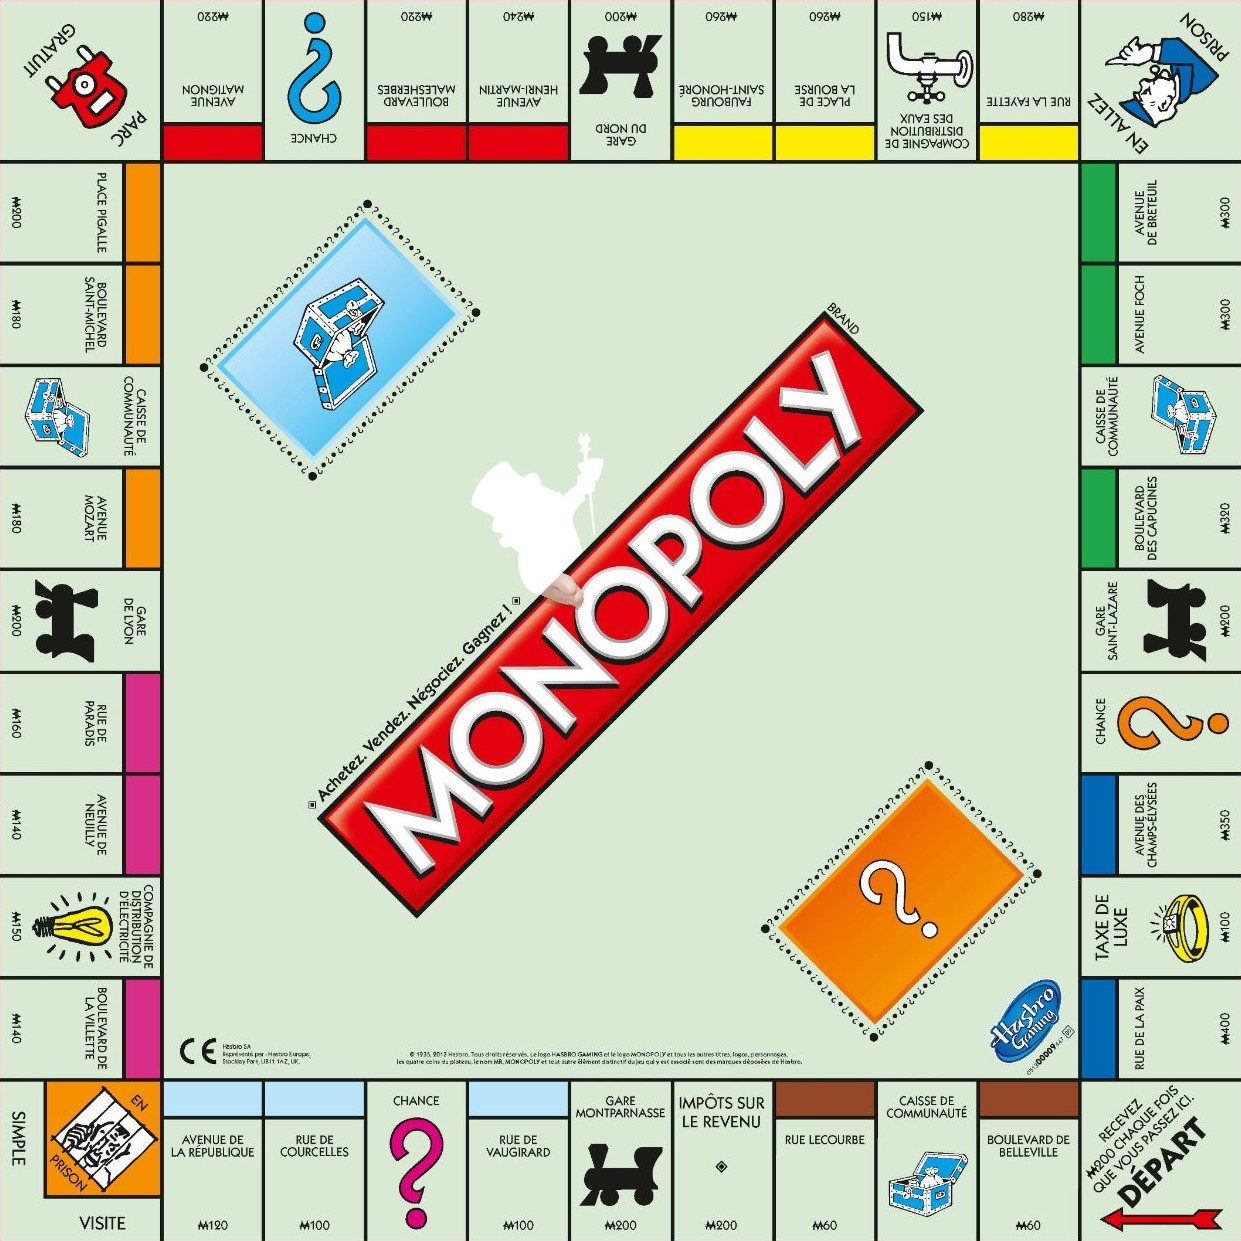



#### Going to Jail: 

If a player is instructed to go to Jail (at any point during his turn), his turn ends regardless of the doubles status. The player will stay at most 3 turns in Jail. He can go out of jail in one of the following manner:
- Paying is way out (50\$). In this case the token goes to "Just visiting" and the player can throw is dice as usual. 
- Using a Chance card. This is similar as paying 50\$.
- Rolling the dice. If there is a double, the player can go out and moves forwards of the number obtained with the dice. Note that in this case the player cannot roll the dice again (the double was "used" to get out of jail).


After the third turn, if the player does not get a double, he *must* pay 50\$ and moves of the number of spaces obtained with the dice.


## 1. Setting up the Markov Chain

In this first part we will set up the parameters for a Markov chain that models the movements of the token of the board from turn to turn. 
We make the following simplification to the rules: 
- Double with the Dice does not allow a second roll.
- We do not consider the cards in the Chance and Community chest slots.
- When getting into Jail, the player always pays 50\$ at the first turn to get out of jail.


We start by constructing the markov chain.

In [1]:
import numpy as np
import pandas as pd
# print numpy width with 1000
np.set_printoptions(linewidth=1000)
pd.set_option('display.width', 1000)

#Sorry the street names are in French! 
#you can replace it with the colors as in the table file
squares = [
    "Départ",
    "Boulevard de Belleville",
    "Caisse de Communauté-1",
    "Rue Lecourbe",
    "Impôts sur le Revenu",
    "Gare Montparnasse",
    "Rue de Vaugirard",
    "Chance-1",
    "Rue de Courcelles",
    "Avenue de la République",
    "Visite de Prison",
    "Boulevard de la Villette",
    "Compagnie de Distribution d Électricité",
    "Avenue de Neuilly",
    "Rue de Paradis",
    "Gare de Lyon",
    "Avenue Mozart",
    "Caisse de Communauté-2",
    "Boulevard Saint-Michel",
    "Place Pigalle",
    "Parc Gratuit",
    "Avenue Matignon",
    "Chance-2",
    "Boulevard Malesherbes",
    "Avenue Henri-Martin",
    "Gare du Nord",
    "Faubourg Saint-Honoré",
    "Place de la Bourse",
    "Compagnie de Distribution des Eaux",
    "Rue La Fayette",
    "Allez en Prison",
    "Avenue de Breteuil",
    "Avenue Foch",
    "Caisse de communauté-3",
    "Boulevard des Capucines",
    "Gare Saint-Lazare",
    "Chance-3",
    "Avenue des Champs-Élysées",
    "Taxe de Luxe",
    "Rue de la Paix",
    # "Prison"
]
nsquares = len(squares)

##Some easy links
dict_squares = dict((x, i) for i, x in enumerate(squares))
iprison = dict_squares["Allez en Prison"] ## This square is in fact never visited 
ivisite = dict_squares["Visite de Prison"]

#Construct a 11 element array with all dice probabilities
TwoDices = np.convolve(np.ones(6)/6, np.ones(6)/6)


## The initial probability. Note that we set a vector to allow matrix product computations 
## afterwards.
pi = np.zeros((1, nsquares))
pi[0,0] = 1


##Set up the Transition Matrix
A = np.zeros((nsquares, nsquares), dtype=np.float64)
tmp = np.zeros(nsquares, dtype=np.float64)
tmp[:11] = TwoDices
for i in range(nsquares):
    if i == iprison:
        continue
    A[i,] = np.roll(tmp, i+1)

A[:, ivisite] += A[:, iprison]
A[:, iprison] = 0.0

test_df = pd.DataFrame(A, columns=squares, index=squares)
test_df.style.format("{:.3f}")
print(test_df)


                                           Départ  Boulevard de Belleville  Caisse de Communauté-1  Rue Lecourbe  Impôts sur le Revenu  Gare Montparnasse  Rue de Vaugirard  Chance-1  Rue de Courcelles  Avenue de la République  ...  Allez en Prison  Avenue de Breteuil  Avenue Foch  Caisse de communauté-3  Boulevard des Capucines  Gare Saint-Lazare  Chance-3  Avenue des Champs-Élysées  Taxe de Luxe  Rue de la Paix
Départ                                   0.000000                 0.027778                0.055556      0.083333              0.111111           0.138889          0.166667  0.138889           0.111111                 0.083333  ...              0.0            0.000000     0.000000                0.000000                 0.000000           0.000000  0.000000                   0.000000      0.000000        0.000000
Boulevard de Belleville                  0.000000                 0.000000                0.027778      0.055556              0.083333           0.111111          0.138


## 2. After a few game turns.

Compute the probability of occupation on the board after a few turns of games. You will produce a set of histograms in the like of the one below


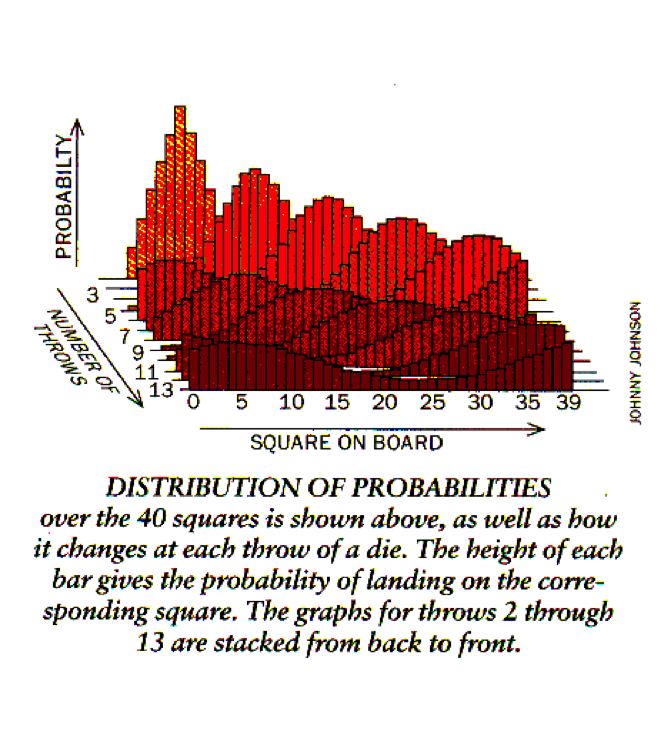


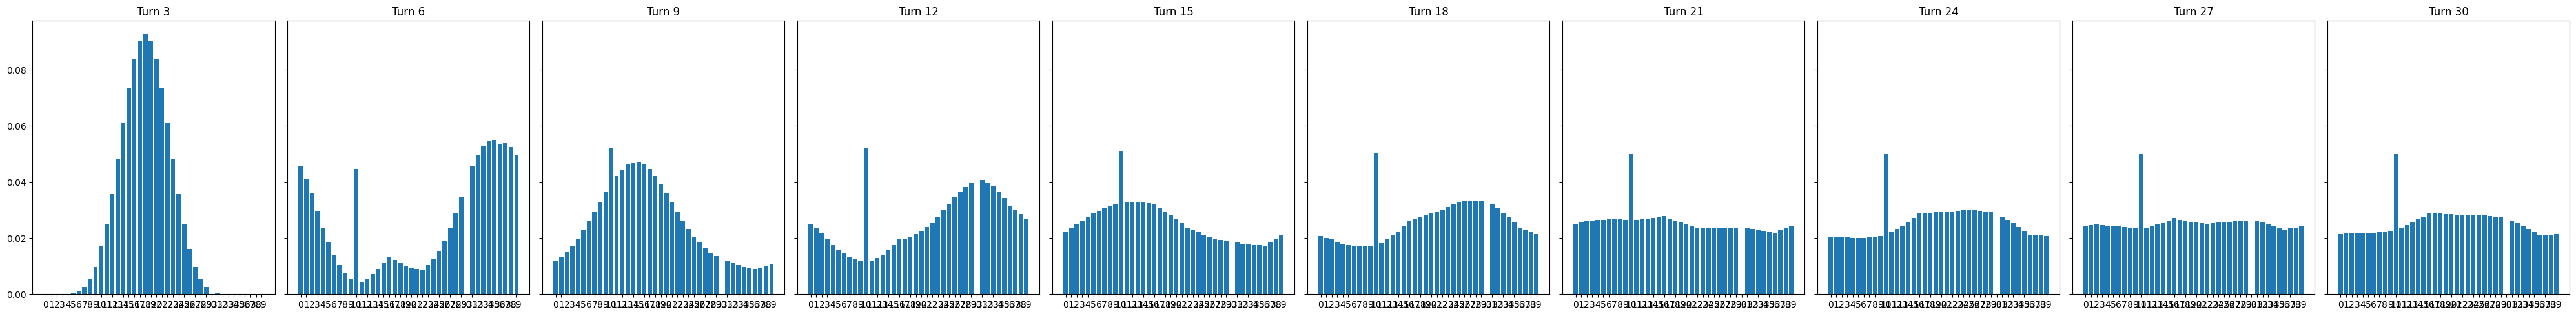

In [2]:
import matplotlib.pyplot as plt

pi_tmp = pi.copy()
N = 30
plot_each_N = 3
fig, axes = plt.subplots(1, N // plot_each_N, figsize=(40,5), sharey=True)
for i in range(N):
    pi_tmp = pi_tmp @ A
    if (i + 1) % plot_each_N == 0:
        axes[i // plot_each_N].bar(range(nsquares), pi_tmp.flatten())
        axes[i // plot_each_N].set_title(f'Turn {i + 1}')
        axes[i // plot_each_N].set_xticks(range(nsquares))
        axes[i // plot_each_N].set_xticklabels([i for i in range(nsquares)])
plt.tight_layout()
plt.show()

## 3.a Computing the stationary distribution


Compute the stationary distribution $\mu$ of the Markov Chain, by using either one of the following properties:
 - $\lim_{n\rightarrow \infty} A^n = \mu$
 - $\mu \cdot A = \mu$. In other word $\mu$ is the eigenvector associated with the eigenvalue $1$.
 
Both can be obtained with the linear algebra functions of numpy. 

Verify that you get something similar to this image (this will not be exactly the same as it was obtained from a more detailled model):

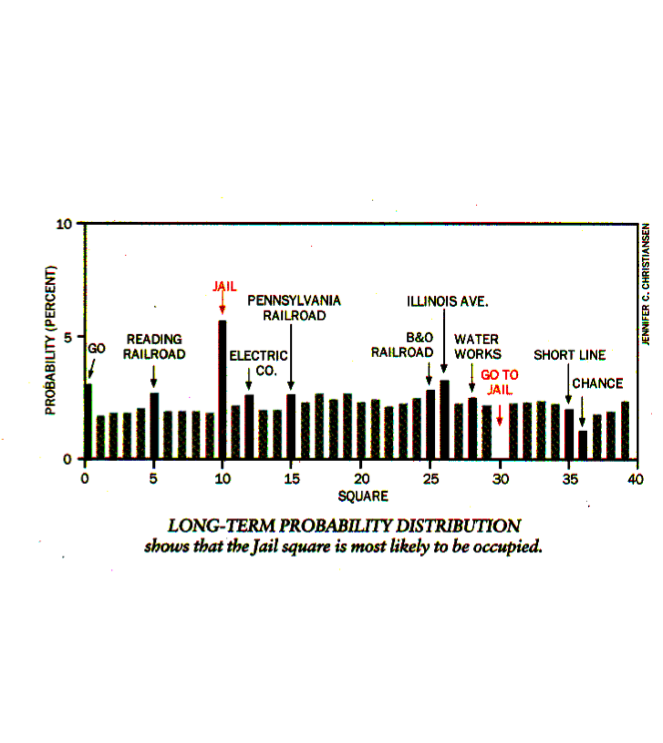


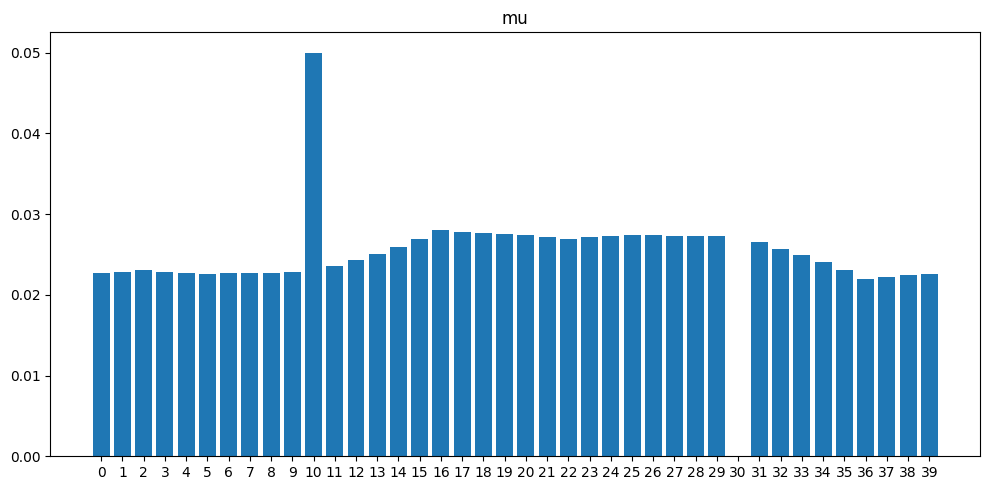

In [3]:
#np.linalg.matrix_power is one function you can use
mu_end = np.linalg.matrix_power(A, 69)[0,:]

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(range(nsquares), mu_end.flatten())
ax.set_title(f'mu')
ax.set_xticks(range(nsquares))
ax.set_xticklabels([i for i in range(nsquares)])
plt.tight_layout()
plt.show()

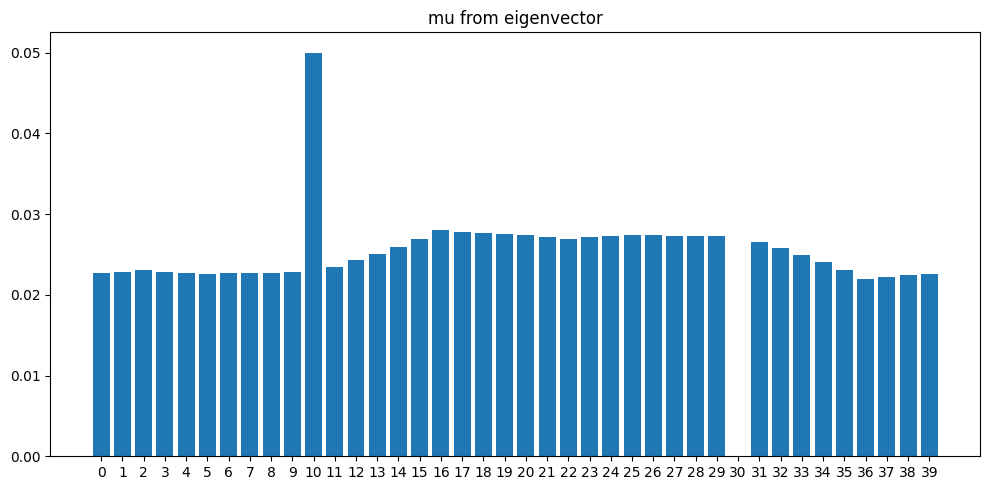

In [4]:
eig_vals, eig_vecs = np.linalg.eig(A.T)
eig_val_1_idx = np.argmin(np.abs(eig_vals - 1.0))
mu_eig = np.real(eig_vecs[:, eig_val_1_idx])
mu_eig = mu_eig / np.sum(mu_eig)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(range(nsquares), mu_eig.flatten())
ax.set_title(f'mu from eigenvector')
ax.set_xticks(range(nsquares))
ax.set_xticklabels([i for i in range(nsquares)])
plt.tight_layout()
plt.show()

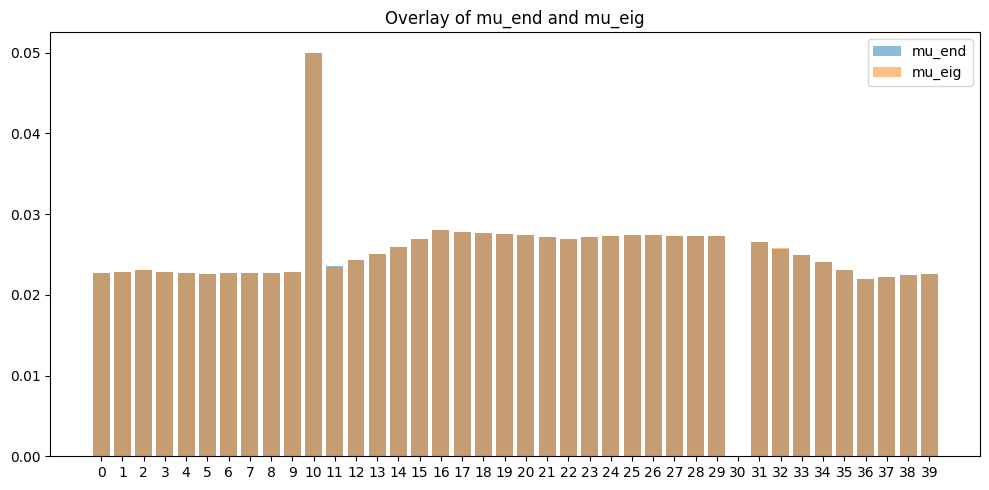

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(range(nsquares), mu_end.flatten(), alpha=0.5, label='mu_end')
ax.bar(range(nsquares), mu_eig.flatten(), alpha=0.5, label='mu_eig')
ax.set_title(f'Overlay of mu_end and mu_eig')
ax.set_xticks(range(nsquares))
ax.set_xticklabels([i for i in range(nsquares)])
ax.legend()
plt.tight_layout()
plt.show()

Can you explain why some locations are more visited than others?

> The "Visite de Prison" location is visited more often as the other ones as there is the field "Allez en Prison" that sends directly to this location, thus resulting in more combined probability. Resulting from this, the squares after "Visite de Prison" (i.e. "Gare de Lyon") is also more visited than the squares before.

## 3b. Convergence to the stationnary distribution

Use the successive powers of the matrix to determine the number of turns after which the chain converged to the stationary distribution (_e.g._ when the difference between the distribution of the rows of the matrix and the stationnary distribution is below 1%)



In [6]:
def rel_diff(mu1, mu2):
    maxs = np.maximum(mu1, mu2)
    abss = np.abs(mu1 - mu2)
    nonzero = maxs != 0
    return np.max(abss[nonzero] / maxs[nonzero])
    
mu_test = pi.copy()
count = 0
while rel_diff(mu_eig, mu_test) > 0.0004:
    mu_test = mu_test @ A
    count += 1
print(f'Convergence reached after {count} multiplications')

Convergence reached after 69 multiplications


## 3c. Evaluating investments   

We provide in attachment a table with all the incomes associated to the various properties of the board. Let's see how we can use that information to understand how to evaluate the various real estate investments on the board.

For each square $k$ of the monopoly, we thus know the cost $c_{k}$ of the property, the price $h_k$ of an house and the rent $r_{k,h}$ with $h$ houses. The total cost of a property with $h$ house is $c_{k,h}= c_k + h\cdot h_k$ 

1. Verify that the expected income per opponent turn on square $k$ is $i_{k,h} = \mu_k \cdot r_{k,h}$ and compute this value for all square and all number of houses. For instance a property where an opponent as 5% chance of landing with a rent of 100\$ provides an expected income per turn of 5\$.

2. Now an interesting quantity is the expected number of opponents turns before we are able to return on our investment with buying the property. For instance if the property mentionned in q.1 costed 50\$, given that we expect to earn 5\$ per turn with no house, our average waiting time before returning on our investment will be after $\frac{50}{5}=10$ opponent turns. Verify that the general formula for this value is:
$$
e_{k,h} = \frac{c_{k,h}} {i_{k,h}}
$$

3. compute $e_{k,h}$ for all square and all number of houses and check the most rentable properties, as a function of the number of houses.

4. (optional). Compute the expected number of turns to get a return of investment on a given color.


5. A classical recommendation for Monopoly is to buy orange properties, can you back up this claim?

In [7]:
# read monopoly square data in Monopoly_square_data.csv
df = pd.read_csv('./Data/Monopoly_squares_data.csv', index_col=0)
df["French Slots"] = squares
# reorder columns to have French Slots first
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index("French Slots")))
df = df[cols]
mu = mu_eig.flatten()

# Compute i_k_h 
types = ["RENT_empty_property", "RENT_1house", "RENT_2houses", "RENT_3houses", "RENT_4houses", "RENT_hotel"]
for t in types:
    t_col = t.split("RENT_")[1]
    df[f"i_{t_col}"] = mu * df[t]
    # reorder columns to have i_k_h after RENT_k_h
    cols = df.columns.tolist()
    rent_idx = cols.index(t)
    i_rent_idx = cols.index(f"i_{t_col}")
    # move i_rent_idx to rent_idx + 1
    cols.insert(rent_idx + 1, cols.pop(i_rent_idx))
    df = df[cols]

# Compute e_k_h
for t in types:
    t_col = t.split("RENT_")[1]
    multiply = 0
    if t_col[0].isdigit():
        multiply = int(t_col[0])
    if "hotel" in t_col:
        multiply = 5
    c = df[f"Cost"] + df[f"house_cost"] * multiply
    df[f"e_{t_col}"] = c / df[f"i_{t_col}"]
    # reorder columns to have e_k_h after i_k_h
    cols = df.columns.tolist()
    i_rent_idx = cols.index(f"i_{t_col}")
    e_rent_idx = cols.index(f"e_{t_col}")
    # move e_rent_idx to i_rent_idx + 1
    cols.insert(i_rent_idx + 1, cols.pop(e_rent_idx))
    df = df[cols]
    # print the name of the field with the minimum e_k_h
    print(f'Minimum e_{t_col} is for {df.loc[df[f"e_{t_col}"].idxmin()]["French Slots"]} with {df[f"e_{t_col}"].min():.2f} turns')

df["color"] = df.index.str.split(" ").str[:-1].str.join(" ")
df["i_color_set"] = mu * df["RENT_color_set"]
df["e_color_set"] = 0.0
for idx, row in df.iterrows():
    color = idx
    if not color.split(" ")[-1].isdigit():
        continue
    color_base = " ".join(color.split(" ")[:-1])
    # sum all costs for this color base
    cost = df[df["color"] == color_base]["Cost"].sum()
    i_color_sum = df[df["color"] == color_base]["i_color_set"].sum()
    if i_color_sum == 0:
        continue
    df.loc[idx, "e_color_set"] = cost / i_color_sum

    # reorder columns to have i_color_set and e_color_set after RENT_color_set
    cols = df.columns.tolist()
    rent_idx = cols.index("RENT_color_set")
    i_rent_idx = cols.index("i_color_set")
    e_rent_idx = cols.index("e_color_set")
    # move i_rent_idx to rent_idx + 1
    cols.insert(rent_idx + 1, cols.pop(i_rent_idx))
    # move e_rent_idx to rent_idx + 2
    cols.insert(rent_idx + 2, cols.pop(e_rent_idx))
    df = df[cols]


display(df)

color_df = df[["color", "e_color_set"]].drop_duplicates().reset_index(drop=True)
# drop all if e_color_set is 0
color_df = color_df[color_df["e_color_set"] > 0].reset_index(drop=True).drop_duplicates()
display(color_df)
# print the color sets with minimum e_color_set
min_e_color = color_df.loc[color_df["e_color_set"].idxmin()]
print(f'Minimum e_color_set is for {min_e_color["color"]} with {min_e_color["e_color_set"]:.2f} turns')
# print the second minimum e_color_set
second_min_e_color = color_df.sort_values(by="e_color_set").iloc[1]
print(f'Second minimum e_color_set is for {second_min_e_color["color"]} with {second_min_e_color["e_color_set"]:.2f} turns')

Minimum e_empty_property is for Rue de la Paix with 355.05 turns
Minimum e_1house is for Rue La Fayette with 131.55 turns
Minimum e_2houses is for Rue La Fayette with 59.15 turns
Minimum e_3houses is for Place Pigalle with 30.34 turns
Minimum e_4houses is for Place Pigalle with 27.30 turns
Minimum e_hotel is for Place Pigalle with 25.48 turns


,French Slots,Cost,RENT_empty_property,i_empty_property,e_empty_property,RENT_color_set,i_color_set,e_color_set,RENT_1house,i_1house,...,i_3houses,e_3houses,RENT_4houses,i_4houses,e_4houses,RENT_hotel,i_hotel,e_hotel,house_cost,color
Slot,,,,,,,,,,,,,,,,,,,,,
Go,Départ,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
Brown 1,Boulevard de Belleville,60.0,2.0,0.045674,1313.666337,4.0,0.091347,437.915574,10.0,0.228368,...,2.055316,102.174048,160.0,3.653896,71.156927,250.0,5.709212,54.298209,50.0,Brown
Community Chest,Caisse de Communauté-1,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Community
Brown 2,Rue Lecourbe,60.0,4.0,0.091339,656.893458,8.0,0.182678,437.915574,20.0,0.456695,...,4.110256,51.091713,320.0,7.307121,35.581729,450.0,10.275639,30.168440,50.0,Brown
Income Tax,Impôts sur le Revenu,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Income
Railroad 1,Gare Montparnasse,200.0,NaN,NaN,NaN,NaN,NaN,0.000000,25.0,0.565653,...,2.262611,NaN,200.0,4.525223,NaN,NaN,NaN,NaN,NaN,Railroad
Light Blue 1,Rue de Vaugirard,100.0,6.0,0.135846,736.129593,12.0,0.271691,352.094185,30.0,0.679228,...,6.113054,40.896088,400.0,9.056376,33.125832,550.0,12.452518,28.106766,50.0,Light Blue
Chance,Chance-1,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
Light Blue 2,Rue de Courcelles,100.0,6.0,0.136492,732.644797,12.0,0.272984,352.094185,30.0,0.682459,...,6.142131,40.702489,400.0,9.099453,32.969016,550.0,12.511747,27.973710,50.0,Light Blue


,color,e_color_set
0,Brown,437.915574
1,Light Blue,352.094185
2,Pink,275.947606
3,Utility,83.191676
4,Orange,229.812618
5,Red,223.052566
6,Yellow,215.473222
7,Green,226.454276
8,Dark Blue,196.888980


Minimum e_color_set is for Utility with 83.19 turns
Second minimum e_color_set is for Dark Blue with 196.89 turns


/tmp/ipykernel_679197/3035732928.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


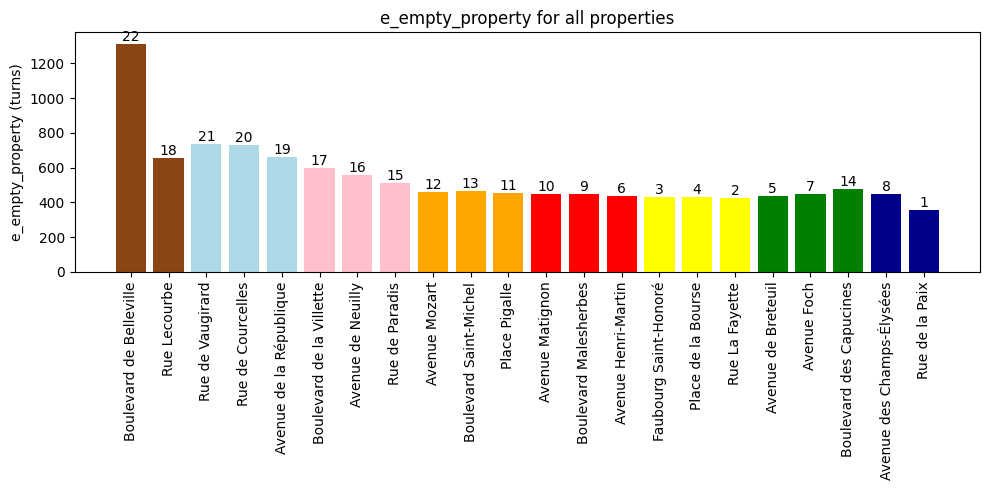

/tmp/ipykernel_679197/3035732928.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


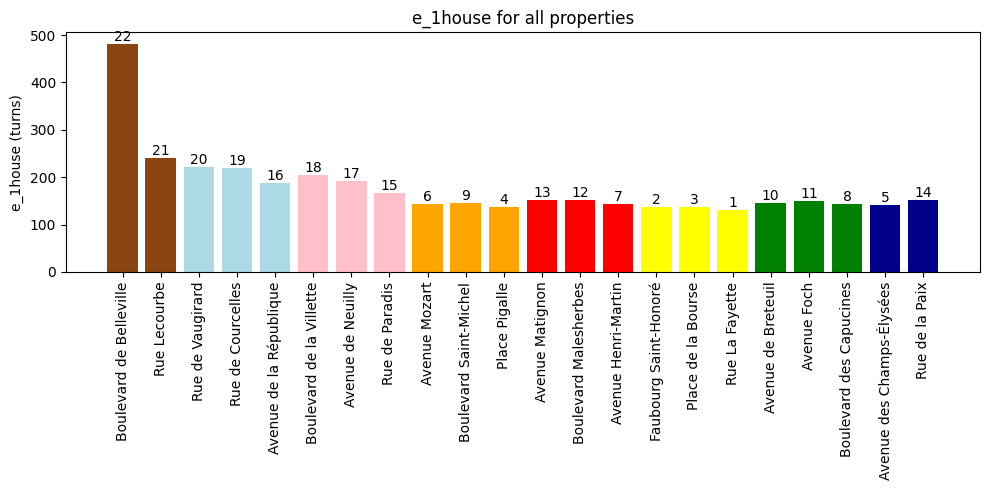

/tmp/ipykernel_679197/3035732928.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


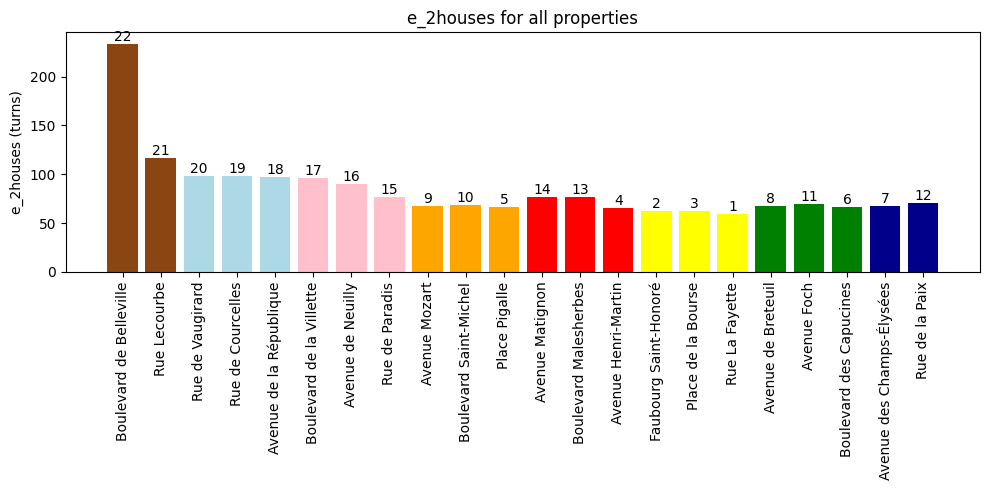

/tmp/ipykernel_679197/3035732928.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


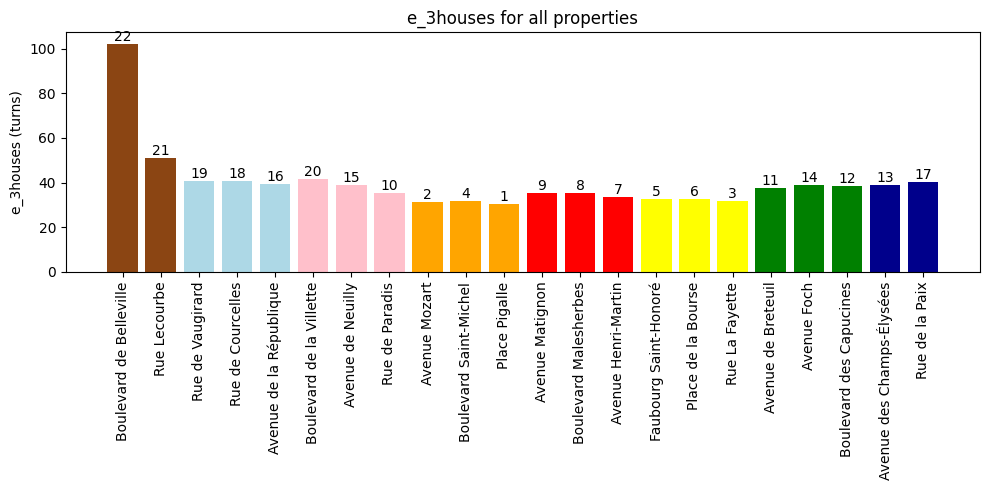

/tmp/ipykernel_679197/3035732928.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


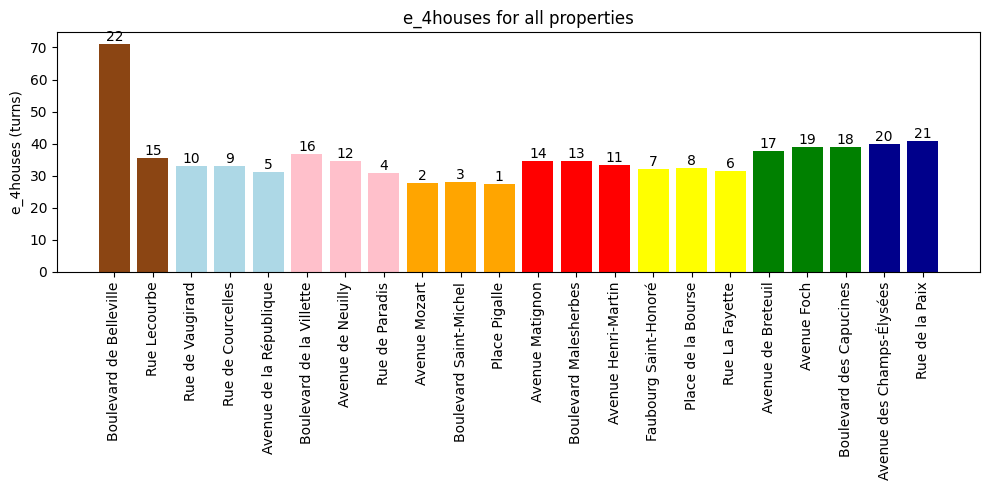

/tmp/ipykernel_679197/3035732928.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prop_df["French Slots"], rotation=90)


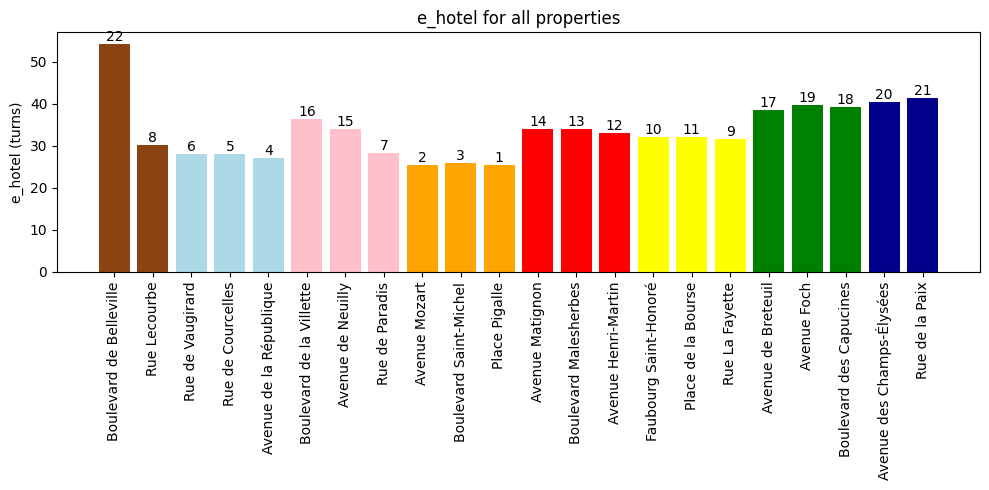

In [20]:
# Plot the e_ houses for all properties per type one plot each

colors = {
    "Brown": "#8B4513",
    "Light Blue": "#ADD8E6",
    "Pink": "#FFC0CB",
    "Orange": "#FFA500",
    "Red": "#FF0000",
    "Yellow": "#FFFF00",
    "Green": "#008000",
    "Dark Blue": "#00008B"
}


import matplotlib.pyplot as plt
types = ["empty_property", "1house", "2houses", "3houses", "4houses", "hotel"]
for t_col in types:
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    prop_df = df[~df[f"e_{t_col}"].isna()]
    # color them after the color column
    ax.bar(prop_df["French Slots"], prop_df[f"e_{t_col}"], color=prop_df["color"].map(colors))
    ax.set_title(f'e_{t_col} for all properties')
    ax.set_xticklabels(prop_df["French Slots"], rotation=90)
    ax.set_ylabel(f'e_{t_col} (turns)')
    # add the order index on top of each bar, lowest e_k_h gets 1, second lowest gets 2, etc.
    order_idxs = prop_df[f"e_{t_col}"].rank(method='min').astype(int)
    for i, order_idx in enumerate(order_idxs):
        ax.text(i, prop_df[f"e_{t_col}"].iloc[i], str(order_idx), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    

> The claim that orange properties are the best investment can be backed up by looking at $e$ as the expected number of turns to get a return of investment on property. However this only applis to 4 houses or hotel investments. For 3 houses yellow can compete with orange. For two houses or less, yellow has generally a lower $e$ than orange, making it a better investment.

## 4. Improving the model

By using the article provided on the moodle (also reproduced [at this adress](http://www.math.yorku.ca/Who/Faculty/Steprans/Courses/2042/Monopoly/Stewart4.html)), design a more realistic transition matrix that would take into account double on the dice as well as the traditional getting out of jail.

You will integrate the following ingredients:
  - Double allow the player to do a second roll.
  - After three double the player goes to jail.
  - To simplify, we also hypothesize that the player cannot buy properties on the intermediate squares in a serie of doubles. 
  - Player always try to get out of jail by throwing the dice up to three times
  - (optional) Account for the cards in Chance and community chests that redirect the token to other cases (more details are given in the article and you can look online what are the statistics for the cards)

To take this information into account in the Markov chain you can increase the state space by consider for each square the number of doubles you did when you landed on it. So now each square will correspond to 3 states in the Markov chain, the ID of the square, together with an additional field that stores the information about the number of doubles. 

For instance imagine you start from (0, "Départ"):
  - if you throw two 3, that's a double and you will land on square 6 ("Rue de Vaugirard") while keeping the information that you did a double so you will be in state (1, "Rue de Vaugirard"). 
  - if you throw a 2 and a 4, that's not a double and you will land on state (0, "Rue de Vaugirard").

In [9]:
## Design the improved transition matrix here







Recompute the values of question 2 and 3a with this new matrix and comment on possible difference.

In [10]:
## Compute powers of the matrix and the stationary distribution

